In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import session_info
session_info.show()

In [2]:
import genomic_features as gf
ensdb = gf.ensembl.annotation(species="Hsapiens", version="109")
genes = ensdb.genes()
genes.head(3)

,gene_id,gene_name,gene_biotype,gene_seq_start,gene_seq_end,seq_name,seq_strand,seq_coord_system,description,gene_id_version,canonical_transcript
0,ENSG00000000003,TSPAN6,protein_coding,100627108,100639991,X,-1,chromosome,tetraspanin 6 [Source:HGNC Symbol;Acc:HGNC:11858],ENSG00000000003.15,ENST00000373020
1,ENSG00000000005,TNMD,protein_coding,100584936,100599885,X,1,chromosome,tenomodulin [Source:HGNC Symbol;Acc:HGNC:17757],ENSG00000000005.6,ENST00000373031
2,ENSG00000000419,DPM1,protein_coding,50934867,50959140,20,-1,chromosome,dolichyl-phosphate mannosyltransferase subunit...,ENSG00000000419.14,ENST00000371588


Aims:
- Compare T21 vs Healthy cell types using DEG analysis
- A problem is that all the T21 samples are female, so this will capture sex-specific DEGs --> will annotate `sex_specific` genes by comparing M vs F in healthy atlas first
- Another issue is the ages: The T21 samples are PCW13/14 only. Therefore DEGs will capture age changes. To limit this I can subset healthy data to similar ages.

# Read in adata

In [3]:
adata = sc.read("/nfs/team205/heart/anndata_objects/Foetal/trisomy21/AtlasT21IntegratedRaw.h5ad")
adata

AnnData object with n_obs × n_vars = 373831 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'region', 'age', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'donor_by_library-prep', 'multiplexed', 'SOC | status', 'SOC | log_prob_singleton', 'SOC | log_prob_doublet', 'batch_key', '_scvi_batch', 'FACSgate', 'fine_grain', 'mid_grain', 'coarse_grain', 'sex', 'week', 'trimester', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', '_scvi_labels', 'stress_score', 'hb1_score', 'MidGrainModified', 'leiden', 'original_or_new', 'age_days', 'diagnosis', 'batch', 'cell_type', 'scANVI_predictions', 'coarse_pred

In [4]:
pd.crosstab(adata.obs.diagnosis,adata.obs.age_days)

age_days,31.0,39.0,43.0,46.0,47.0,49.0,50.0,52.0,54.0,55.0,60.0,62.0,65.0,66.0,75.0,84.0,91.0,98.0,105.0,140.0
diagnosis,,,,,,,,,,,,,,,,,,,,
Atlas,2490,13770,6854,9702,4129,2660,9121,5662,12985,7948,3907,17547,2436,6412,6376,7268,38234,9708,25386,104878
T21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22096,54262,0,0


In [5]:
adata.X.data

array([1., 1., 5., ..., 2., 1., 1.], dtype=float32)

In [6]:
adata.layers["counts"]=adata.X.copy()

In [7]:
adata.shape

(373831, 36601)

# Define sex-specific genes

In [8]:
print(adata.shape)
atlas_adata=adata[adata.obs['diagnosis']=='Atlas']
print(atlas_adata.shape)

(373831, 36601)
(297473, 36601)


In [9]:
adata.obs.sex.value_counts()

sex
male      242969
female    130862
Name: count, dtype: int64

In [10]:
sc.pp.normalize_total(atlas_adata,target_sum=1e4)
sc.pp.log1p(atlas_adata)

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/scanpy_env/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/scanpy_env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


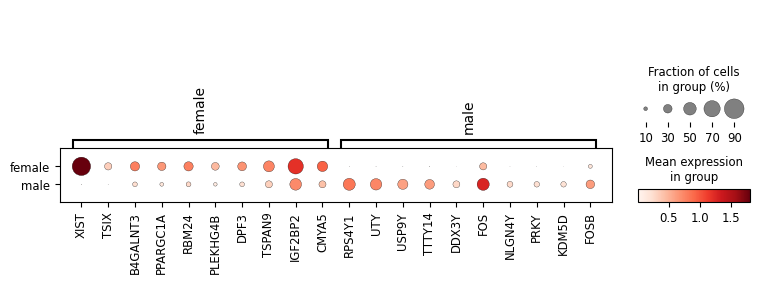

In [11]:
sc.tl.rank_genes_groups(atlas_adata,groupby='sex')
sc.pl.rank_genes_groups_dotplot(atlas_adata)

In [12]:
sex_genes=sc.get.rank_genes_groups_df(atlas_adata,group='male')
sex_genes=sex_genes.reset_index()
sex_genes=sex_genes.merge(genes.drop_duplicates('gene_name'), left_on='names', right_on='gene_name',how='left')
sex_genes['sex_chromosome']=sex_genes.seq_name.isin(['X','Y'])
sex_genes=sex_genes.set_index('names')
sex_genes

,index,scores,logfoldchanges,pvals,pvals_adj,gene_id,gene_name,gene_biotype,gene_seq_start,gene_seq_end,seq_name,seq_strand,seq_coord_system,description,gene_id_version,canonical_transcript,sex_chromosome
names,,,,,,,,,,,,,,,,,
RPS4Y1,0,349.128479,8.804938,0.0,0.0,ENSG00000129824,RPS4Y1,protein_coding,2841602.0,2932000.0,Y,1.0,chromosome,ribosomal protein S4 Y-linked 1 [Source:HGNC S...,ENSG00000129824.16,ENST00000250784,True
UTY,1,321.847595,8.432717,0.0,0.0,ENSG00000183878,UTY,protein_coding,13234577.0,13480673.0,Y,-1.0,chromosome,ubiquitously transcribed tetratricopeptide rep...,ENSG00000183878.16,ENST00000545955,True
USP9Y,2,281.157562,8.035007,0.0,0.0,ENSG00000114374,USP9Y,protein_coding,12537650.0,12860839.0,Y,1.0,chromosome,ubiquitin specific peptidase 9 Y-linked [Sourc...,ENSG00000114374.13,ENST00000338981,True
TTTY14,3,270.557770,7.294281,0.0,0.0,ENSG00000176728,TTTY14,lncRNA,18772706.0,19077416.0,Y,-1.0,chromosome,"testis-specific transcript, Y-linked 14 [Sourc...",ENSG00000176728.10,ENST00000651734,True
DDX3Y,4,196.956009,8.438138,0.0,0.0,ENSG00000067048,DDX3Y,protein_coding,12904108.0,12920478.0,Y,1.0,chromosome,DEAD-box helicase 3 Y-linked [Source:HGNC Symb...,ENSG00000067048.17,ENST00000336079,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RBM24,36596,-139.024048,-1.936886,0.0,0.0,ENSG00000112183,RBM24,protein_coding,17281361.0,17293871.0,6,1.0,chromosome,RNA binding motif protein 24 [Source:HGNC Symb...,ENSG00000112183.15,ENST00000379052,False
PPARGC1A,36597,-144.833740,-2.327109,0.0,0.0,ENSG00000109819,PPARGC1A,protein_coding,23755041.0,23904089.0,4,-1.0,chromosome,PPARG coactivator 1 alpha [Source:HGNC Symbol;...,ENSG00000109819.9,ENST00000264867,False
B4GALNT3,36598,-147.896667,-2.157929,0.0,0.0,ENSG00000139044,B4GALNT3,protein_coding,459939.0,563509.0,12,1.0,chromosome,"beta-1,4-N-acetyl-galactosaminyltransferase 3 ...",ENSG00000139044.12,ENST00000266383,False


<Axes: >

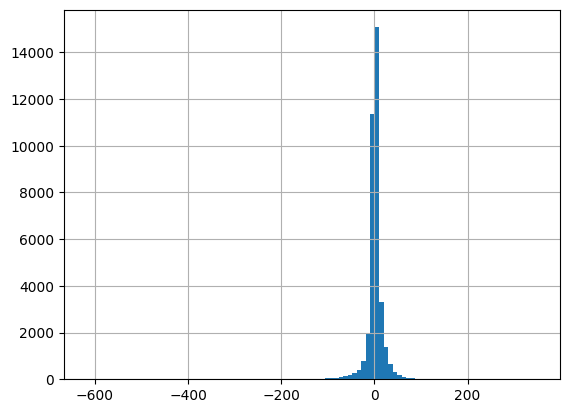

In [13]:
sex_genes.scores.hist(bins=100)

In [14]:
# Calculate the mean and standard deviation
mean_scores = sex_genes['scores'].mean()
std_scores = sex_genes['scores'].std()

# Calculate the upper and lower bounds
lower_bound = mean_scores - 2 * std_scores
upper_bound = mean_scores + 2 * std_scores

# Add a new column 'significant' based on whether scores exceed these bounds
sex_genes['sex_specific'] = (sex_genes['scores'] > upper_bound) | (sex_genes['scores'] < lower_bound)

# Annotate as male or female
sex_genes['sex'] = np.where(sex_genes['scores'] > 0, 'male', 'female')
sex_genes['sex'] = sex_genes['sex'].astype('category')

# Print the bounds for reference
print(f"Lower bound: {lower_bound}")
print(f"Upper bound: {upper_bound}")

Lower bound: -33.01948547363281
Upper bound: 37.317161560058594


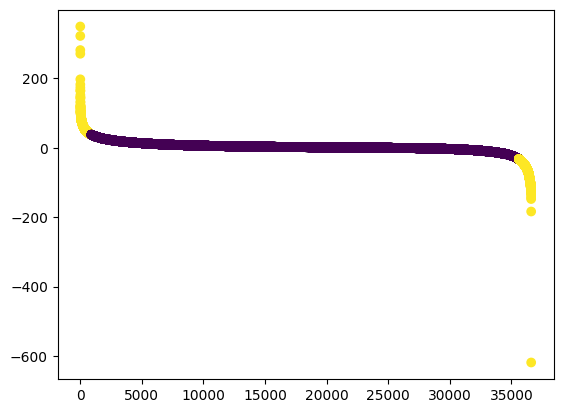

In [15]:
plt.scatter(x=sex_genes['index'],y=sex_genes.scores, c=sex_genes.sex_specific)

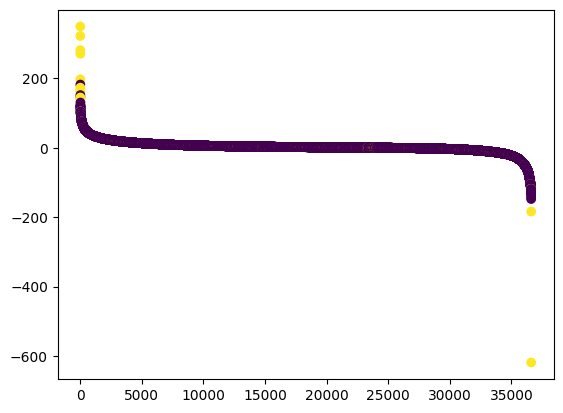

In [16]:
plt.scatter(x=sex_genes['index'],y=sex_genes.scores, c=sex_genes.sex_chromosome)

In [17]:
sex_genes[sex_genes.sex_specific].sex.value_counts()

sex
female    1004
male       903
Name: count, dtype: int64

In [18]:
sex_genes[sex_genes.sex_chromosome].sex.value_counts()

sex
male      564
female    450
Name: count, dtype: int64

In [19]:
sex_genes.loc["PRDM16"]

index                                                               36531
scores                                                        -101.175774
logfoldchanges                                                  -1.500243
pvals                                                                 0.0
pvals_adj                                                             0.0
gene_id                                                   ENSG00000142611
gene_name                                                          PRDM16
gene_biotype                                               protein_coding
gene_seq_start                                                  3069168.0
gene_seq_end                                                    3438621.0
seq_name                                                                1
seq_strand                                                            1.0
seq_coord_system                                               chromosome
description             PR/SET domain 

# Compare T21 and healthy cell states

In [20]:
# subset to similar ages, so we are not capturing
print(adata.shape)
adata = adata[(adata.obs.age_days >= 75) & (adata.obs.age_days <= 105)]
print(adata.shape)

(373831, 36601)
(163330, 36601)


In [21]:
sc.pp.normalize_total(adata,target_sum=1e4)
sc.pp.log1p(adata)

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/scanpy_env/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [22]:
adata.var=adata.var.merge(sex_genes[['sex_specific','sex','sex_chromosome']], left_index=True, right_index=True)

In [24]:
# make a label to compare
adata.obs['fine_grain_T21_status']=adata.obs['fine_grain_integrated'].astype('str')+'_'+adata.obs['diagnosis'].astype('str')
adata.obs['fine_grain_T21_status'] = adata.obs['fine_grain_T21_status'].astype('category')

adata.obs['mid_grain_T21_status']=adata.obs['mid_grain_integrated'].astype('str')+'_'+adata.obs['diagnosis'].astype('str')
adata.obs['mid_grain_T21_status'] = adata.obs['mid_grain_T21_status'].astype('category')

## Compact T21 vs Compact Healthy

In [25]:
all_cell_types=adata.obs.fine_grain_T21_status.unique().tolist()

list_of_cell_types=[
    'VentricularCardiomyocytesLeftCompact',
    #'VentricularCardiomyocytesLeftTrabeculated',
    #'VentricularCardiomyocytesRightCompact',
    #'VentricularCardiomyocytesRightTrabeculated',
]

groups = [cell for cell in all_cell_types if any(term in cell for term in list_of_cell_types)]
groups

['VentricularCardiomyocytesLeftCompact_Atlas',
 'VentricularCardiomyocytesLeftCompact_T21']

In [26]:
tmp_adata=adata[adata.obs.fine_grain_T21_status.isin(groups)]
print(tmp_adata.shape)
#tmp_adata=tmp_adata[:,~adata.var.sex_chromosome]
#print(tmp_adata.shape)

sc.tl.rank_genes_groups(tmp_adata,
                        groupby='fine_grain_T21_status',
                       groups=groups)

(13877, 36601)


/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/scanpy_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/scanpy_env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


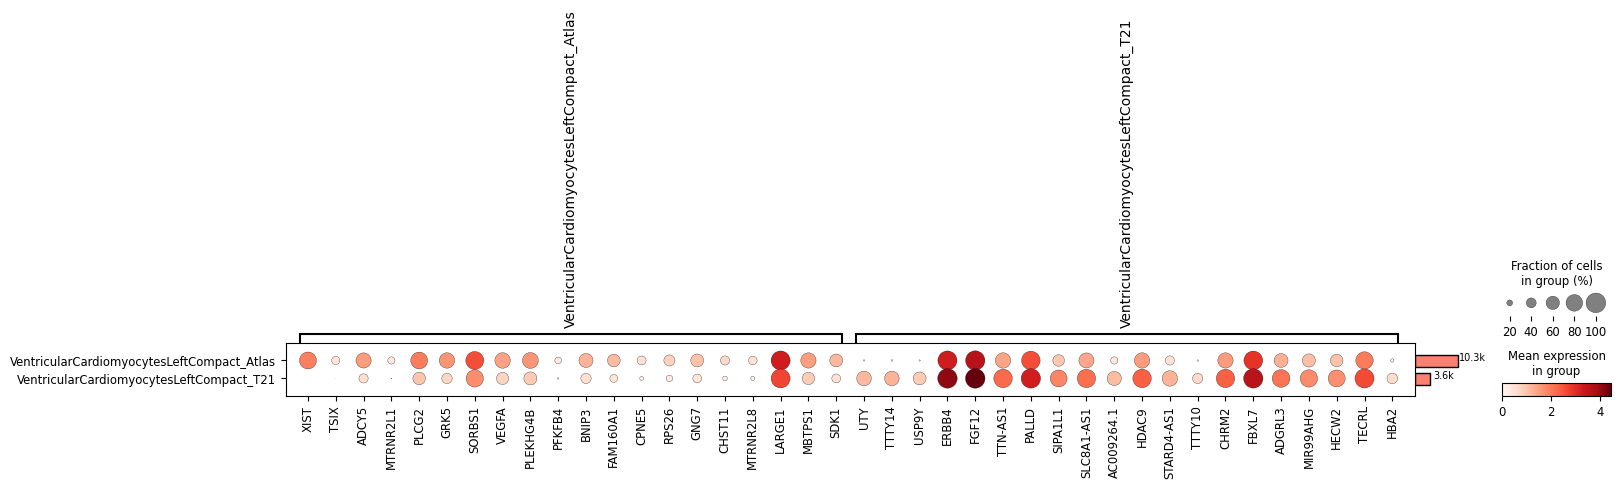

In [27]:
dp=sc.pl.rank_genes_groups_dotplot(tmp_adata,
                               n_genes=20,
                                   dendrogram=False,
                                 return_fig=True)
dp.add_totals().show()

### REDUCED in T21

In [45]:
print("These genes are HIGH in "+groups[0]+" and LOW in "+groups[1])
df=sc.get.rank_genes_groups_df(tmp_adata,group=groups[0],pval_cutoff=0.01,log2fc_min=0)
df=df.merge(sex_genes.drop_duplicates('gene_name')[['sex_specific','seq_name','sex_chromosome','description']], left_on='names', right_index=True,how='left')
down=df.set_index('names')
down

These genes are HIGH in VentricularCardiomyocytesLeftCompact_Atlas and LOW in VentricularCardiomyocytesLeftCompact_T21


,scores,logfoldchanges,pvals,pvals_adj,sex_specific,seq_name,sex_chromosome,description
names,,,,,,,,
XIST,191.669556,32.454060,0.000000,0.000000,True,X,True,X inactive specific transcript [Source:HGNC Sy...
TSIX,63.295986,9.206864,0.000000,0.000000,True,X,True,"TSIX transcript, XIST antisense RNA [Source:HG..."
ADCY5,53.595493,2.221355,0.000000,0.000000,True,3,False,adenylate cyclase 5 [Source:HGNC Symbol;Acc:HG...
MTRNR2L1,52.350365,5.184286,0.000000,0.000000,NaN,NaN,NaN,NaN
PLCG2,50.277988,1.936767,0.000000,0.000000,True,16,False,phospholipase C gamma 2 [Source:HGNC Symbol;Ac...
...,...,...,...,...,...,...,...,...
NAB2,3.075882,0.616303,0.002106,0.009835,False,12,False,NGFI-A binding protein 2 [Source:HGNC Symbol;A...
CXCR4,3.075694,20.020432,0.002106,0.009835,False,2,False,C-X-C motif chemokine receptor 4 [Source:HGNC ...
HMOX1,3.074272,1.955118,0.002115,0.009872,False,22,False,heme oxygenase 1 [Source:HGNC Symbol;Acc:HGNC:...


In [ ]:
T21_down_receptors={
    'PLXNA4':["SEMA3A"],
}

In [ ]:
T21_down_ligands={
    'VEGFA':["KDR","FLT1","NRP1","NRP2"],
}

In [ ]:
glycolysis_enzymes_down_in_T21=['PFKFB4','PFKP','GPI']

### INCREASED in T21

In [46]:
print("These genes are LOW in "+groups[0]+" and HIGH in "+groups[1])
df=sc.get.rank_genes_groups_df(tmp_adata,group=groups[1],pval_cutoff=0.01,log2fc_min=0)
df=df.merge(sex_genes.drop_duplicates('gene_name')[['sex_specific','seq_name','sex_chromosome','description']], left_on='names', right_index=True,how='left')
up=df.set_index('names')
up=up.sort_values('scores', ascending=False)
up

These genes are LOW in VentricularCardiomyocytesLeftCompact_Atlas and HIGH in VentricularCardiomyocytesLeftCompact_T21


,scores,logfoldchanges,pvals,pvals_adj,sex_specific,seq_name,sex_chromosome,description
names,,,,,,,,
UTY,71.277763,5.180484,0.000000,0.000000,True,Y,True,ubiquitously transcribed tetratricopeptide rep...
TTTY14,68.345657,4.998813,0.000000,0.000000,True,Y,True,"testis-specific transcript, Y-linked 14 [Sourc..."
USP9Y,57.679634,4.902645,0.000000,0.000000,True,Y,True,ubiquitin specific peptidase 9 Y-linked [Sourc...
ERBB4,54.355984,1.206761,0.000000,0.000000,True,2,False,erb-b2 receptor tyrosine kinase 4 [Source:HGNC...
FGF12,54.155704,1.220004,0.000000,0.000000,True,3,False,fibroblast growth factor 12 [Source:HGNC Symbo...
...,...,...,...,...,...,...,...,...
KIAA0930,3.073664,1.222603,0.002126,0.009919,False,22,False,KIAA0930 [Source:HGNC Symbol;Acc:HGNC:1314]
MCAT,3.072494,0.573157,0.002133,0.009946,False,22,False,malonyl-CoA-acyl carrier protein transacylase ...
SLC35A1,3.072436,0.322994,0.002133,0.009946,False,6,False,solute carrier family 35 member A1 [Source:HGN...


In [ ]:
T21_up_receptors={
    'ERBB4':["BTC","HBEGF","NRG2","NRG3","NRG4"],
    "ADGRL3":["FLRT2","FLRT3"],
    "ROBO1":['SLIT1',"SLIT2","SLIT3"],
    "NCAM1":["NCAM1"],
    "LGR4":["RSPO1","RSPO2","RSPO3","RSPO4"]
    
}

In [ ]:
T21_up_ligands={
    'FGF12':["BTC","HBEGF","NRG2","NRG3","NRG4"],
    "EFNA5":["EPHA1","EPHA2","EPHB2","EPHA3","EPHB4","EPHA5","EPHA7","EPHA8"],
    "SEMA5A":['PLXNB3', 'PLXNB1'],
    "BMP5":["BMPR2",'BMPR1A', 'BMPR1B', 'ACVR1', 'ACVR1B', 'ACVR1C']
    
}

## Save for CPDB

'VentricularCardiomyocytesLeftCompact'

In [48]:
# save for CPDB
T21_up = up.dropna()
T21_up = T21_up[T21_up.sex_chromosome==False]
T21_up['cluster']=groups[0].split("_")[0]

Atlas_up = down.dropna()
Atlas_up = Atlas_up[Atlas_up.sex_chromosome==False]
Atlas_up['cluster']=groups[0].split("_")[0]
Atlas_up = Atlas_up.reset_index()
Atlas_up[['cluster','names']].to_csv(path_or_buf=f"/lustre/scratch126/cellgen/team205/jc48/jupyter/cpdb/data",index=False)

,cluster,names
0,VentricularCardiomyocytesLeftCompact,ADCY5
1,VentricularCardiomyocytesLeftCompact,PLCG2
2,VentricularCardiomyocytesLeftCompact,GRK5
3,VentricularCardiomyocytesLeftCompact,SORBS1
4,VentricularCardiomyocytesLeftCompact,VEGFA
...,...,...
1547,VentricularCardiomyocytesLeftCompact,NAB2
1548,VentricularCardiomyocytesLeftCompact,CXCR4
1549,VentricularCardiomyocytesLeftCompact,HMOX1
1550,VentricularCardiomyocytesLeftCompact,SPACA3
